## Read the data and plot them

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def parse_measured_date(date_str):
    """
    Try to parse a date string using two possible formats.
    Returns NaT if neither format works.
    """
    for fmt in ("%m/%d/%Y %H:%M", "%m/%d/%y %H:%M"):
        try:
            return pd.to_datetime(date_str, format=fmt)
        except Exception:
            continue
    return pd.NaT

# ------------------------------
# Process Measured Data
# ------------------------------
measured_df = pd.read_csv("rsfmeasureddata2011.csv")

# Fill missing values in the first row with 0
measured_df.iloc[0] = measured_df.iloc[0].fillna(0)

# Parse dates in the measured data
measured_df["Date and Time"] = measured_df["Date and Time"].apply(parse_measured_date)
measured_df = measured_df.dropna(subset=["Date and Time"])
# Replace year with 2011 (to ignore year differences)
measured_df["Date and Time"] = measured_df["Date and Time"].apply(lambda dt: dt.replace(year=2011))
measured_df.set_index("Date and Time", inplace=True)

# ------------------------------
# Process Weather Data
# ------------------------------
weather_df = pd.read_csv(
    "rsfweatherdata2011.csv",
    parse_dates=["DATE AND TIME"],
    date_parser=lambda x: pd.to_datetime(x, format="%m/%d/%y %H:%M", errors='coerce')
)

# Insert a row of zeros at the top:
# Construct a dictionary with all columns set to 0. For the "DATE AND TIME" column, use a dummy valid timestamp.
zero_row = {col: 0 for col in weather_df.columns}
zero_row["DATE AND TIME"] = pd.to_datetime("2011-01-01 00:00")
# Prepend this row to the DataFrame
weather_df = pd.concat([pd.DataFrame([zero_row]), weather_df], ignore_index=True)

weather_df = weather_df.dropna(subset=["DATE AND TIME"])
# Replace year with 2011 (for consistency)
weather_df["DATE AND TIME"] = weather_df["DATE AND TIME"].apply(lambda dt: dt.replace(year=2011))
weather_df.set_index("DATE AND TIME", inplace=True)

# ------------------------------
# Normalization and Sensor Error Correction for Measured Data
# ------------------------------
# Work on a copy for measured data normalization.
measured_df_norm = measured_df.copy()

# Flip sign for "PV (kW)" because values are negative.
if "PV (kW)" in measured_df_norm.columns:
    measured_df_norm["PV (kW)"] = -measured_df_norm["PV (kW)"]

# Select columns to normalize
measured_cols = ["Total Building (kW)", "PV (kW)"]
measured_df_norm[measured_cols] = (measured_df_norm[measured_cols] - measured_df_norm[measured_cols].min()) / \
                                  (measured_df_norm[measured_cols].max() - measured_df_norm[measured_cols].min())

# ------------------------------
# Normalization and Sensor Error Correction for Weather Data
# ------------------------------
# Convert weather data columns to numeric and drop entirely non-numeric ones.
numeric_weather_df = weather_df.apply(pd.to_numeric, errors='coerce')
numeric_weather_df = numeric_weather_df.dropna(axis=1, how='all')

# Flip sign for selected weather columns.
cols_to_flip = [
    "Avg Global 90-South PSP [W/m^2]",
    "Avg Deck Dry Bulb Temp [deg C]",
    "Ave Global 90 South Irradiance (W/ft2)"
]
for col in cols_to_flip:
    if col in numeric_weather_df.columns:
        numeric_weather_df[col] = -numeric_weather_df[col]

# --- Sensor Error Correction (Option 1: Time-based interpolation) ---
# Define the error period.
error_start = pd.to_datetime("2011-05-14 23:00")
error_end = pd.to_datetime("2011-05-16 07:00")
error_mask = (numeric_weather_df.index >= error_start) & (numeric_weather_df.index <= error_end)

# Specify the columns with sensor errors.
cols_error = ["Avg Global 90-South PSP [W/m^2]", "Ave Global 90 South Irradiance (W/ft2)"]
# Set the error period values to NaN.
numeric_weather_df.loc[error_mask, cols_error] = np.nan

# Apply time-based interpolation (based on the datetime index) to these columns.
numeric_weather_df[cols_error] = numeric_weather_df[cols_error].interpolate(method='time')

# Now normalize all numeric weather columns.
numeric_weather_df_norm = (numeric_weather_df - numeric_weather_df.min()) / (numeric_weather_df.max() - numeric_weather_df.min())

# ------------------------------
# Plotting the Full Measured Data (example plots)
# ------------------------------
#for col in measured_cols:
#    plt.figure(figsize=(12, 6))
#    plt.plot(measured_df_norm.index, measured_df_norm[col], label=col)
#    plt.xlabel("Date (Month/Day, Year Ignored)")
#    plt.ylabel("Normalized Value")
#    plt.title(f"Measured Data Time Series for {col} (Normalized)")
#    plt.legend()
#    plt.show()

# ------------------------------
# Plotting the Full Weather Data (example plots)
# ------------------------------
#for col in numeric_weather_df_norm.columns:
#    plt.figure(figsize=(12, 6))
#    plt.plot(numeric_weather_df_norm.index, numeric_weather_df_norm[col], label=col)
#    plt.xlabel("Date (Month/Day, Year Ignored)")
#    plt.ylabel("Normalized Value")
#    plt.title(f"Weather Data Time Series for {col} (Normalized)")
#    plt.legend()
#    plt.show()

/tmp/ipykernel_1445493/3341767597.py:35: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  weather_df = pd.read_csv(


## Print and check the data is correctly read in

In [2]:
# Create a dictionary where keys are the dates and values are lists of hourly measurements for each column
daily_total_building = measured_df_norm["Total Building (kW)"].groupby(pd.Grouper(freq='D')).apply(list)
daily_pv = measured_df_norm["PV (kW)"].groupby(pd.Grouper(freq='D')).apply(list)

# Display the first day's Total Building data
first_day_date = daily_total_building.index[0]
print(f"Total Building data for {first_day_date.date()}:")
print(daily_total_building.iloc[0])

# Similarly, for PV
print(f"\nPV data for {first_day_date.date()}:")
print(daily_pv.iloc[0])

# Create a dictionary where keys are the dates and values are lists of hourly measurements for each column
daily_AvgDeckDryBulbTemp = numeric_weather_df_norm["Avg Deck Dry Bulb Temp [deg C]"].groupby(pd.Grouper(freq='D')).apply(list)
daily_AvgGlobalPhotometricLI210 = numeric_weather_df_norm["Avg Global Photometric LI-210 [klux]"].groupby(pd.Grouper(freq='D')).apply(list)

# Display the first day's Avg Deck Dry Bulb Temp
first_day_date = daily_AvgDeckDryBulbTemp.index[0]
print(f"\nAvg Deck Dry Bulb Temp [deg C] data for {first_day_date.date()}:")
print(daily_AvgDeckDryBulbTemp.iloc[0])

# Similarly, for PV
print(f"\n Avg Global Photometric LI-210 [klux] data for {first_day_date.date()}:")
print(daily_AvgGlobalPhotometricLI210.iloc[0])

Total Building data for 2011-01-01:
[0.0, 0.5831533477321814, 0.5280777537796977, 0.5647948164146869, 0.531317494600432, 0.4244060475161987, 0.4103671706263499, 0.37688984881209503, 0.40712742980561556, 0.30669546436285094, 0.326133909287257, 0.3207343412526998, 0.3023758099352052, 0.23650107991360692, 0.24946004319654427, 0.234341252699784, 0.26997840172786175, 0.34233261339092874, 0.32721382289416845, 0.4103671706263499, 0.5140388768898488, 0.5485961123110151, 0.5140388768898488, 0.4762419006479482]

PV data for 2011-01-01:
[0.005226480836236934, 0.005226480836236934, 0.005226480836236934, 0.005226480836236934, 0.005226480836236934, 0.005226480836236934, 0.003484320557491289, 0.005226480836236934, 0.010452961672473868, 0.047038327526132406, 0.029616724738675958, 0.0313588850174216, 0.11149825783972125, 0.16898954703832753, 0.05749128919860627, 0.07665505226480836, 0.027874564459930314, 0.0156794425087108, 0.005226480836236934, 0.005226480836236934, 0.005226480836236934, 0.00348432055

In [3]:
# Assuming daily_dataset, daily_total_building, and daily_pv are already defined as in the previous snippets

#print("Length of daily_dataset:", len(daily_dataset))
print("Length of daily_total_building:", len(daily_total_building))
print("Length of daily_pv:", len(daily_pv))

print("Length of daily_AvgDeckDryBulbTemp:", len(daily_AvgDeckDryBulbTemp))
print("Length of daily_AvgGlobalPhotometricLI210:", len(daily_AvgGlobalPhotometricLI210))

Length of daily_total_building: 365
Length of daily_pv: 365
Length of daily_AvgDeckDryBulbTemp: 365
Length of daily_AvgGlobalPhotometricLI210: 365


## Zoom in to process the 2011 spring data

In [4]:
# Filter the spring period data from the daily_total_building Series
spring_data_totalbuilding = daily_AvgDeckDryBulbTemp["2011-01-01":"2011-03-31"]

spring_data_pv = daily_pv.loc["2011-01-01":"2011-03-31"]

spring_data_temp = daily_AvgDeckDryBulbTemp.loc["2011-01-01":"2011-03-31"]

spring_data_photo = daily_AvgGlobalPhotometricLI210.loc["2011-01-01":"2011-03-31"]

# Build sliding window samples for spring data: each x is 7 days and y is the 8th day.
spring_x_totalbuilding = []
spring_y_totalbuilding = []
for i in range(len(spring_data_totalbuilding) - 7):
    # x: list of 7 consecutive days (each day is a list of hourly values)
    spring_x_totalbuilding.append(spring_data_totalbuilding.iloc[i:i+7].tolist())
    # y: the following day’s data (list of hourly values)
    spring_y_totalbuilding.append(spring_data_totalbuilding.iloc[i+7])

spring_x_pv = []
spring_y_pv = []
for i in range(len(spring_data_pv) - 7):
    # x: list of 7 consecutive days (each day is a list of hourly values)
    spring_x_pv.append(spring_data_pv.iloc[i:i+7].tolist())
    # y: the following day’s data (list of hourly values)
    spring_y_pv.append(spring_data_pv.iloc[i+7])

spring_x_temp = []
spring_y_temp = []
for i in range(len(spring_data_temp) - 7):
    # x: list of 7 consecutive days (each day is a list of hourly values)
    spring_x_temp.append(spring_data_temp.iloc[i:i+7].tolist())
    # y: the following day’s data (list of hourly values)
    spring_y_temp.append(spring_data_temp.iloc[i+7])

spring_x_photo = []
spring_y_photo = []
for i in range(len(spring_data_photo) - 7):
    # x: list of 7 consecutive days (each day is a list of hourly values)
    spring_x_photo.append(spring_data_photo.iloc[i:i+7].tolist())
    # y: the following day’s data (list of hourly values)
    spring_y_photo.append(spring_data_photo.iloc[i+7])

print("Length of spring_x_totalbuilding:", len(spring_x_totalbuilding))
print("Length of spring_y_totalbuilding:", len(spring_y_totalbuilding))

print("Length of spring_x_pv:", len(spring_x_pv))
print("Length of spring_y_pv:", len(spring_y_pv))

print("Length of spring_x_temp:", len(spring_x_temp))
print("Length of spring_y_temp:", len(spring_y_temp))

print("Length of spring_x_photo:", len(spring_x_photo))
print("Length of spring_y_photo:", len(spring_y_photo))

Length of spring_x_totalbuilding: 83
Length of spring_y_totalbuilding: 83
Length of spring_x_pv: 83
Length of spring_y_pv: 83
Length of spring_x_temp: 83
Length of spring_y_temp: 83
Length of spring_x_photo: 83
Length of spring_y_photo: 83


## Check the pre-processed data are in the desired shape

In [5]:
spring_x_totalbuilding_array = np.array(spring_x_totalbuilding)
print("shape of spring_x_totalbuilding_array", spring_x_totalbuilding_array.shape)
spring_y_totalbuilding_array = np.array(spring_y_totalbuilding)
print("shape of spring_y_totalbuilding_array", spring_y_totalbuilding_array.shape)

spring_x_pv_array = np.array(spring_x_pv)
print("shape of spring_x_pv_array", spring_x_pv_array.shape)
spring_y_pv_array = np.array(spring_y_pv)
print("shape of spring_y_pv_array", spring_y_pv_array.shape)

spring_x_temp_array = np.array(spring_x_temp)
print("shape of spring_x_temp_array", spring_x_temp_array.shape)
spring_y_temp_array = np.array(spring_y_temp)
print("shape of spring_y_temp_array", spring_y_temp_array.shape)

spring_x_photo_array = np.array(spring_x_photo)
print("shape of spring_x_photo_array", spring_x_photo_array.shape)
spring_y_photo_array = np.array(spring_y_photo)
print("shape of spring_y_photo_array", spring_y_photo_array.shape)

shape of spring_x_totalbuilding_array (83, 7, 24)
shape of spring_y_totalbuilding_array (83, 24)
shape of spring_x_pv_array (83, 7, 24)
shape of spring_y_pv_array (83, 24)
shape of spring_x_temp_array (83, 7, 24)
shape of spring_y_temp_array (83, 24)
shape of spring_x_photo_array (83, 7, 24)
shape of spring_y_photo_array (83, 24)


## Transform lists to numpy arrays

In [6]:
import os
# Force TensorFlow to ignore any GPUs.
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
try:
    tf.config.set_visible_devices([], 'GPU')
except Exception as e:
    print("Error setting visible devices:", e)
print("Visible devices:", tf.config.get_visible_devices())

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from sklearn.preprocessing import MinMaxScaler

# -----------------------------
# Data Loading & Preprocessing
# -----------------------------
# Replace these simulated data arrays with your actual data.
# Here we assume each sample is a sequence of 7 days with 24 hourly values.
# The model will use previous 7 days (for both PV and Global LI-210)
# to predict the next day's 24 PV values.
num_samples = 83  # number of samples in your dataset
timesteps = 7      # 7 days of input
hours = 24         # 24 hourly values per day
output_dim = 24    # predict 24 hourly PV values for the next day

# Simulate data (for demonstration); replace with your actual data
#pv_history = np.random.rand(num_samples, timesteps, hours)
#global_li210 = np.random.rand(num_samples, timesteps, hours)
#pv_target = np.random.rand(num_samples, output_dim)

# -----------------------------
# Check for NaNs in the Data
# -----------------------------
print("spring_x_totalbuilding NaNs:", np.isnan(np.array(spring_x_totalbuilding_array)).sum())
print("spring_y_totalbuilding NaNs:", np.isnan(spring_y_totalbuilding_array).sum())
print("spring_x_pv NaNs:", np.isnan(spring_x_pv_array).sum())
print("spring_y_pv NaNs:", np.isnan(spring_y_pv_array).sum())
print("spring_x_temp NaNs:", np.isnan(spring_x_temp_array).sum())
print("spring_y_temp NaNs:", np.isnan(spring_y_temp_array).sum())
print("spring_x_photo NaNs:", np.isnan(spring_x_photo_array).sum())
print("spring_y_photo NaNs:", np.isnan(spring_y_photo_array).sum())
# If any NaNs are detected, you should decide whether to remove or impute them.

2025-04-08 03:57:31.607865: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744084651.632694 1445493 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744084651.639176 1445493 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-08 03:57:31.674073: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Visible devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
spring_x_totalbuilding NaNs: 0
spring_y_totalbuilding NaNs: 0
spring_x_pv NaNs: 0
spring_y_pv NaNs: 0
spring_x_temp NaNs: 0
spring_y_temp NaNs: 0
spring_x_photo NaNs: 0
spring_y_photo NaNs: 0


2025-04-08 03:57:34.295819: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-04-08 03:57:34.295889: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: me592-hcwu0975
2025-04-08 03:57:34.295898: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: me592-hcwu0975
2025-04-08 03:57:34.296084: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 535.216.1
2025-04-08 03:57:34.296113: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 535.216.1
2025-04-08 03:57:34.296119: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 535.216.1


## Merge the data for MISO application for Total Building prediction

In [7]:
# -----------------------------
# Normalize/Scale the Data
# -----------------------------
def scale_data(data):
    num_samples, timesteps, features = data.shape
    data_reshaped = data.reshape(-1, features)
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data_reshaped)
    return data_scaled.reshape(num_samples, timesteps, features), scaler

# Scale the input features separately
totalbuilding_history_scaled, totalbuilding_scaler = scale_data(spring_x_totalbuilding_array)
pv_history_scaled, pv_scaler = scale_data(spring_x_pv_array)
temp_history_scaled, temp_scaler = scale_data(spring_x_temp_array)
photo_history_scaled, photo_scaler = scale_data(spring_x_photo_array)

# Combine the two targets into one array.
combined_target = spring_y_totalbuilding_array

# Also scale the target variable.
target_scaler = MinMaxScaler()
combined_target_scaled = target_scaler.fit_transform(combined_target)#.reshape(num_samples, output_dim*4)

# Concatenate the two input features along the last axis.
# New shape: (num_samples, timesteps, hours * 2)
X_multivariate = np.concatenate((totalbuilding_history_scaled, temp_history_scaled), axis=-1)

print(combined_target_scaled.shape)
print(X_multivariate.shape)

(83, 24)
(83, 7, 48)


## MISO LSTM model on Spring data (Predicting Total Building using previous Total Building and Dry Bulb Temp)

/home/exouser/.conda/envs/my5920_env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        28,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │         1,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,488 (119.09 KB)

 Trainable params: 30,488 (119.09 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.2778 - val_loss: 0.1384
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1312 - val_loss: 0.1019
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1045 - val_loss: 0.0913
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0905 - val_loss: 0.0903
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0895 - val_loss: 0.0881
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0864 - val_loss: 0.0860
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0852 - val_loss: 0.0837
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0844 - val_loss: 0.0837
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0841 - val_loss: 0.0848
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0839 - val_loss: 0.0840
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0834 - val_loss: 0.0843
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0818 - val_lo

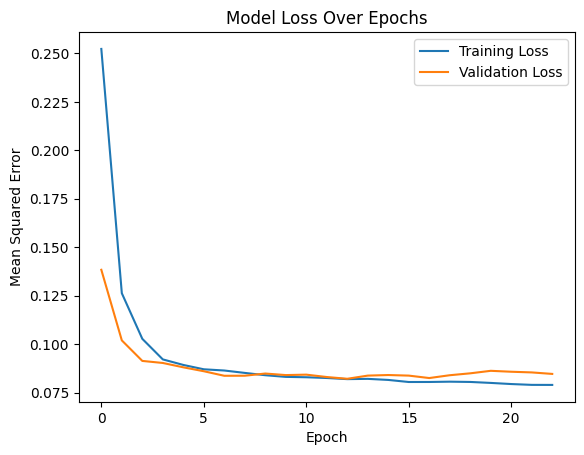

In [8]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# -------------------------------
# Step 1: Prepare the Data
# -------------------------------

# For demonstration purposes, we generate dummy data.
# Replace these with your actual data:
n_samples = 83     # number of samples
n_timesteps = 7    # number of time steps (e.g., 7 days)
n_features = 48    # features per time step (e.g., 4*24 hourly variables)
n_targets = 24     # 48 predicted target variables per sample

# Dummy input: X_multivariate with shape (83, 7, 96)
X_multivariate = np.random.rand(n_samples, n_timesteps, n_features)

# Dummy target: combined_target_scaled with shape (83, 48)
combined_target_scaled = np.random.rand(n_samples, n_targets)

# Split the data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    X_multivariate, combined_target_scaled, test_size=0.2, random_state=42
)

# -------------------------------
# Step 2: Build the LSTM Model
# -------------------------------

# Define the model architecture
model = Sequential()
# LSTM layer to process the sequence data. 64 units can be adjusted.
model.add(LSTM(64, input_shape=(n_timesteps, n_features)))
# Dense output layer with 48 units corresponding to the target dimensions.
model.add(Dense(n_targets))

# Compile the model with MSE loss for regression and the Adam optimizer.
model.compile(loss='mse', optimizer='adam')

# Print the model summary to check the architecture.
model.summary()

# -------------------------------
# Step 3: Train the Model
# -------------------------------

# Use early stopping to prevent overfitting.
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model on the training data and validate on the validation data.
history = model.fit(
    X_train, y_train,
    epochs=100,            # Adjust the number of epochs as needed.
    batch_size=16,         # Adjust batch size based on dataset size.
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)

# -------------------------------
# Step 4: Evaluate and Predict
# -------------------------------

# After training, you can make predictions on the validation set.
predictions = model.predict(X_val)
print("Predictions shape:", predictions.shape)  # Should be (number of validation samples, 48)

# -------------------------------
# (Optional) Plot Training History
# -------------------------------

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.show()

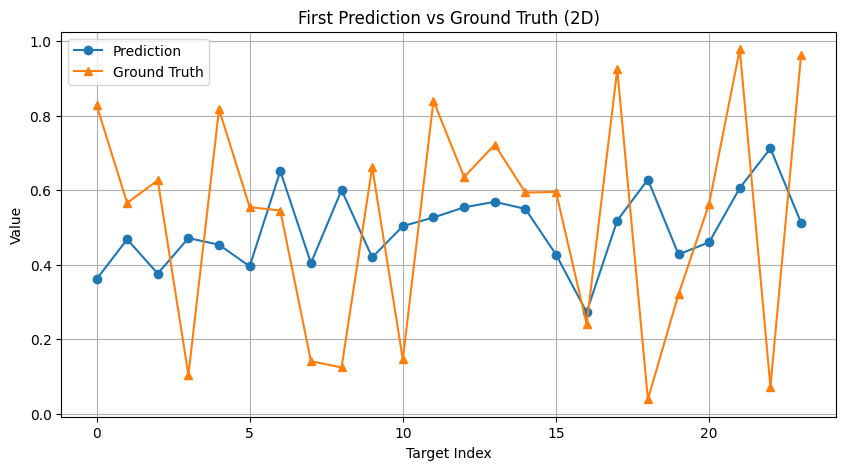

In [10]:
# -------------------------------
# Step 5: Plot the first prediction and corresponding test data in 2D and 3D
# -------------------------------

# Select the first prediction and ground truth values.
first_prediction = predictions[0]   # shape: (48,)
first_ground_truth = y_val[0]       # shape: (48,)
target_indices = np.arange(n_targets)

# ----- 2D Plot -----
plt.figure(figsize=(10, 5))
plt.plot(target_indices, first_prediction, label="Prediction", marker='o')
plt.plot(target_indices, first_ground_truth, label="Ground Truth", marker='^')
plt.title("First Prediction vs Ground Truth (2D)")
plt.xlabel("Target Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

## MISO GRU model on Spring data (Predicting Total Building using previous Total Building and Dry Bulb Temp)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        21,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │         1,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,448 (91.59 KB)

 Trainable params: 23,448 (91.59 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.3198 - val_loss: 0.1653
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1516 - val_loss: 0.1100
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1101 - val_loss: 0.1016
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0975 - val_loss: 0.0957
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0928 - val_loss: 0.0952
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0921 - val_loss: 0.0968
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0909 - val_loss: 0.0938
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0892 - val_loss: 0.0887
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0857 - val_loss: 0.0872
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0858 - val_loss: 0.0877
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0829 - val_loss: 0.0902
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0830 - val_lo

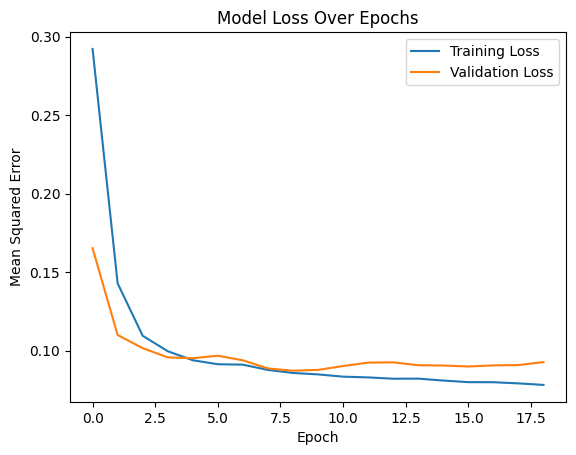

In [9]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# -------------------------------
# Step 1: Prepare the Data
# -------------------------------

# For demonstration purposes, we generate dummy data.
# Replace these with your actual data:
n_samples = 83     # number of samples
n_timesteps = 7    # number of time steps (e.g., 7 days)
n_features = 48    # features per time step (e.g., 4*24 hourly variables)
n_targets = 24     # 48 predicted target variables per sample

# Dummy input: X_multivariate with shape (83, 7, 96)
X_multivariate = np.random.rand(n_samples, n_timesteps, n_features)

# Dummy target: combined_target_scaled with shape (83, 48)
combined_target_scaled = np.random.rand(n_samples, n_targets)

# Split the data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    X_multivariate, combined_target_scaled, test_size=0.2, random_state=42
)

# -------------------------------
# Step 2: Build the LSTM Model
# -------------------------------

# Define the model architecture
model = Sequential()
# LSTM layer to process the sequence data. 64 units can be adjusted.
model.add(GRU(64, input_shape=(n_timesteps, n_features)))
# Dense output layer with 48 units corresponding to the target dimensions.
model.add(Dense(n_targets))

# Compile the model with MSE loss for regression and the Adam optimizer.
model.compile(loss='mse', optimizer='adam')

# Print the model summary to check the architecture.
model.summary()

# -------------------------------
# Step 3: Train the Model
# -------------------------------

# Use early stopping to prevent overfitting.
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model on the training data and validate on the validation data.
history = model.fit(
    X_train, y_train,
    epochs=100,            # Adjust the number of epochs as needed.
    batch_size=16,         # Adjust batch size based on dataset size.
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)

# -------------------------------
# Step 4: Evaluate and Predict
# -------------------------------

# After training, you can make predictions on the validation set.
predictions = model.predict(X_val)
print("Predictions shape:", predictions.shape)  # Should be (number of validation samples, 48)

# -------------------------------
# (Optional) Plot Training History
# -------------------------------

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.show()

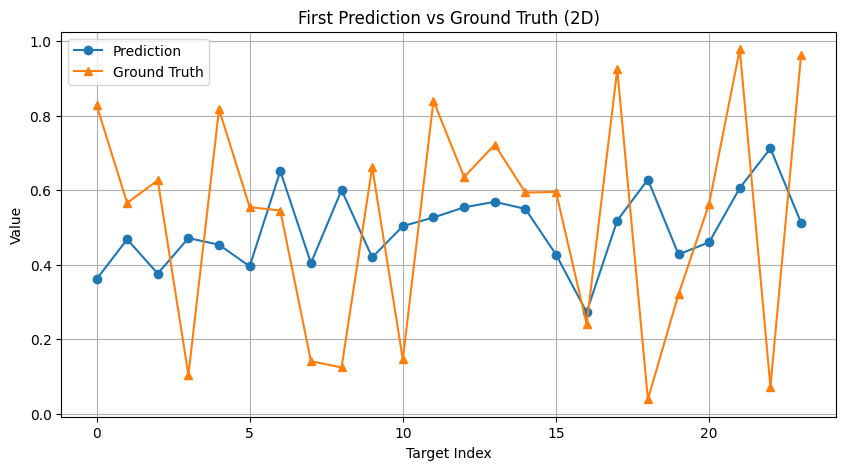

In [11]:
# -------------------------------
# Step 5: Plot the first prediction and corresponding test data in 2D and 3D
# -------------------------------

# Select the first prediction and ground truth values.
first_prediction = predictions[0]   # shape: (48,)
first_ground_truth = y_val[0]       # shape: (48,)
target_indices = np.arange(n_targets)

# ----- 2D Plot -----
plt.figure(figsize=(10, 5))
plt.plot(target_indices, first_prediction, label="Prediction", marker='o')
plt.plot(target_indices, first_ground_truth, label="Ground Truth", marker='^')
plt.title("First Prediction vs Ground Truth (2D)")
plt.xlabel("Target Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()